In [1]:
import utils, models_preprocessing, metrics
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.models import save_model, load_model

In [3]:
from quiver_engine import server

In [4]:
data = np.load('data/imadjust.npy')
labels = np.load('labels/classification.npy')

In [5]:
# model_function = models_preprocessing.compiledConvnet
model_function = models_preprocessing.compiledRegularizedConvnet
auroc = metrics.auroc
accuracy = metrics.accuracy
text = metrics.basicTextMetrics

In [6]:
%matplotlib inline

Epoch 1/1
14000/14000 [==============================] - 104s 7ms/step - loss: 53.1973 - acc: 0.6948
Epoch 1/1
14000/14000 [==============================] - 103s 7ms/step - loss: 6.8822 - acc: 0.7619
Epoch 1/1
14000/14000 [==============================] - 103s 7ms/step - loss: 1.6487 - acc: 0.7824
Epoch 1/1
14000/14000 [==============================] - 103s 7ms/step - loss: 0.8532 - acc: 0.8022
Epoch 1/1
14000/14000 [==============================] - 103s 7ms/step - loss: 0.6282 - acc: 0.8157
Epoch 1/1
14000/14000 [==============================] - 103s 7ms/step - loss: 0.5309 - acc: 0.8269
Epoch 1/1
14000/14000 [==============================] - 104s 7ms/step - loss: 0.4771 - acc: 0.8341
Epoch 1/1
14000/14000 [==============================] - 103s 7ms/step - loss: 0.4432 - acc: 0.8396
Epoch 1/1
14000/14000 [==============================] - 103s 7ms/step - loss: 0.4174 - acc: 0.8511
Epoch 1/1
14000/14000 [==============================] - 103s 7ms/step - loss: 0.4010 - acc: 0.8544

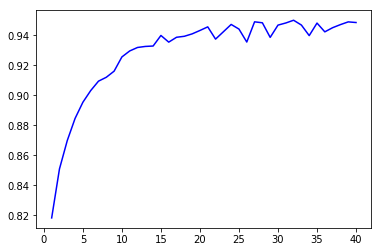

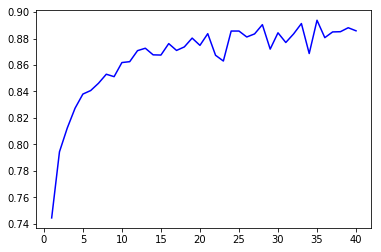

{'epochs': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 'results': [[0.81834683420504317,
   0.85099100373272996,
   0.86987731816576719,
   0.88460128750524591,
   0.89537332845249784,
   0.90313367203373685,
   0.90941543675158221,
   0.9120029497625215,
   0.91607181483884914,
   0.92555431685866452,
   0.92953501722158449,
   0.93184700105936313,
   0.93253978158261086,
   0.93281548408089621,
   0.93984601333725271,
   0.93540727244491029,
   0.93864406137280898,
   0.93929934589408948,
   0.94090560759931308,
   0.94317073587839328,
   0.94556920895337504,
   0.93741460848858638,
   0.9422967150497974,
   0.94718644791649342,
   0.94410114514754362,
   0.93547637139460638,
   0.94892963647019446,
   0.94828469368135182,
   0.93856225191397158,
   0.94674077124596279,
   0.9481560864388574,
   0.9

In [7]:
## Run 1: Compiled ConvNet
utils.epoch_curve(model_function, data, labels, 0.3, range(1,41), [auroc, accuracy])

In [8]:
import os

In [9]:
os.makedirs('models', exist_ok=True)
PATH = 'models/'

In [10]:
save_model(models_preprocessing.compiledConvnet(), PATH+'model_half_reg.hdf5')

In [11]:
model = load_model(PATH+'model_half_reg.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 50, 50, 64)        2368      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               247936    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
__________

In [12]:
import PIL.Image

In [141]:
img = PIL.Image.fromarray(data[15001])

In [142]:
from keras.preprocessing import image

In [143]:
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [144]:
print(img_tensor.shape)

(1, 101, 101, 4)


In [145]:
import matplotlib.pyplot as plt

In [146]:
from keras import models

In [147]:
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [148]:
activations = activation_model.predict(img_tensor)

In [149]:
first_layer_activation = activations[0]

In [150]:
first_layer_activation.shape

(1, 50, 50, 64)

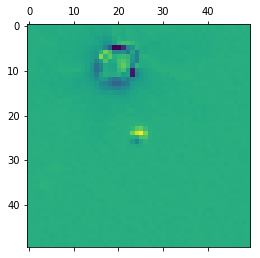

In [151]:
plt.matshow(first_layer_activation[0, :, :, 32], cmap='viridis')

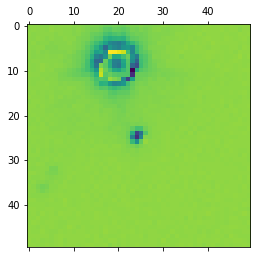

In [152]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

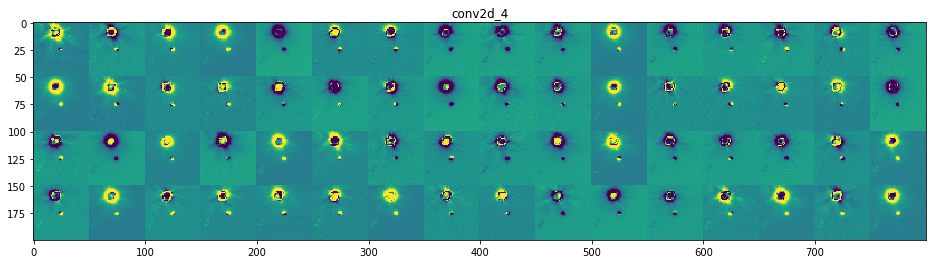

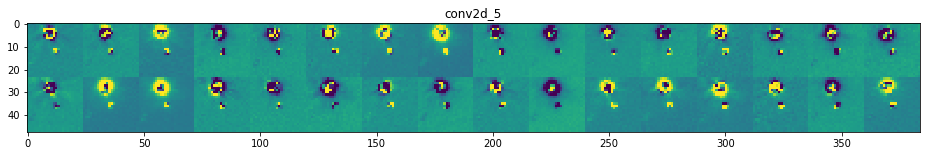

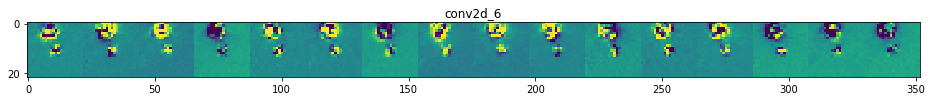

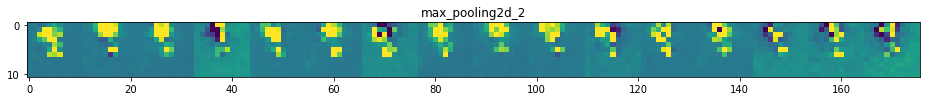

In [153]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col*size : (col+1)*size, row*size : (row+1)*size] = channel_image
    
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                        scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [193]:
preds = model.predict(data)

In [194]:
certain_preds = [(i, preds[i]) for i in range(len(preds)) if preds[i]>=0.5]

In [195]:
len(certain_preds)

337

In [196]:
import itertools

In [197]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [198]:
preds = np.array([1 if preds[i]>=0.5 else 0 for i in range(len(preds))])

In [199]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)

[[11769   210]
 [ 7894   127]]


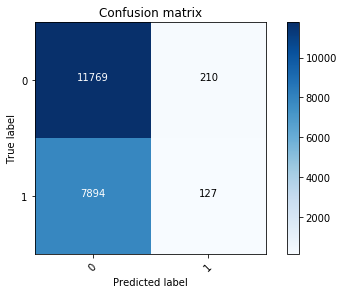

In [200]:
plot_confusion_matrix(cm, [0,1])

In [ ]:
## Run 2: Compiled Regularized ConvNet
#generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
#utils.epoch_curve_generator(model_function, data, labels, generator, 32, 0.3, range(1, 41), [auroc, accuracy])

In [ ]:
## Run 3: Complied Convnet and Compiled Regularized Convnet with 5-fold cross-validation
# utils.cross_validation(model_function, data, labels, 5, 20, metrics_array=text)